In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

In [3]:
# 加载数据
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y=[0],it's a non-cat


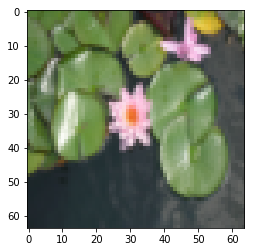

In [4]:
# 展示训练集数据
index = 26
plt.imshow(train_set_x_orig[index])
# train_set_y[:,index] 为[1] 或 [0]， 使用np.squeeze(train_set_y[:,index]) 压缩为 1 或 0，用作classes的索引
print("y=" + str(train_set_y[:,index]) + ",it's a " + classes[np.squeeze(train_set_y[:,index])].decode("utf-8"))

In [5]:
#图像数量
m_train = train_set_y.shape[1] 
m_test =test_set_y.shape[1]
#图像宽度
num_px = train_set_x_orig.shape[1]

print("训练集的数量："+ str(m_train))
print("测试机的数量："+ str(m_test))
print("图片的宽/高："+ str(num_px))
print("图片大小：" + str(num_px) + "," + str(num_px) + "3")
print("训练集图片维数：" + str(train_set_x_orig.shape))
print ("训练集标签维数 : " + str(train_set_y.shape))
print ("测试集图片维数: " + str(test_set_x_orig.shape))
print ("测试集标签维数: " + str(test_set_y.shape))


训练集的数量：209
测试机的数量：50
图片的宽/高：64
图片大小：64,643
训练集图片维数：(209, 64, 64, 3)
训练集标签维数 : (1, 209)
测试集图片维数: (50, 64, 64, 3)
测试集标签维数: (1, 50)


In [6]:
# 训练集、测试集图片降维、转置
# 降维：将每张图片的64*64*3三维矩阵转换为一行，行数=图片数量,训练集由四维变为二维
# 转置: 每一列代表一张图片的数据，列数=图片数量
train_set_x_flatten  = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
print("训练集图片维度："+str(train_set_x_flatten.shape))
print("测试集图片维度："+str(test_set_x_flatten.shape))

训练集图片维度：(12288, 209)
测试集图片维度：(12288, 50)


In [7]:
# 单位化数据集
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

In [8]:
# 激活函数
def sigmoid(z):
    s = 1/(1+ np.exp(-z))
    return s
#测试sigmoid()
print("====================测试sigmoid====================")
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))


    

====================测试sigmoid====================
sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


In [9]:
# 初始化参数
def initialize_with_zeros(dim):
    """
    dim 代表了该层神经元个数,对应于数据集特征的个数，即px*px*3
     w  - 维度为（dim，1）的列向量。
     b  - 初始化的标量（对应偏差）
    """
    w = np.zeros((dim,1))
    b = 0
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    return w,b



In [10]:
# 正和反向传播， 成本函数、渐变函数
def propagate(w,b,X,Y):
    """
    实现前向和后向传播的成本函数及其梯度。
    参数：
        w - 权重，列向量(num_px * num_px * 3，1)
        b - 偏移, 标量
        X - 样本，(num_px * num_px * 3，样本数)
        Y - 标签，行向量（1，样本数）
    返回：
        cost - 成本
        dw - w的损失梯度
        db - b的损失梯度
    """
    m = X.shape[1]
    
    # 正向传播 X ->cost
    A = sigmoid(np.dot(w.T, X) + b) #激活值
    cost = (-1 / m )* np.sum(Y * np.log(A) + (1-Y)*np.log(1-A)) #成本
    
    # 反向传播 
    dw = (1/m) * np.dot(X, (A-Y).T)
    db = 1 / m * np.sum(A - Y)
    
    #使用断言确保数据正确
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    #将dw，db保存在字典
    grads = {"dw":dw, "db":db}
    
    return grads, cost



In [11]:
# 测试 propagate
print("===========测试propagate=============")
#初始化参数
w,b,X,Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]),  np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print("dw=" + str(grads["dw"]))
print("db=" + str(grads["db"]))
print("cost=" + str(cost))

===========测试propagate=============
dw=[[0.99993216]
 [1.99980262]]
db=0.49993523062470574
cost=6.000064773192205


In [12]:
# 梯度下降
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    通过梯度下降算法，找到w和b的局部最优
    
    参数：
        w - 权重，列向量(num_px * num_px * 3，1)
        b - 偏移, 标量
        X - 样本，(num_px * num_px * 3，样本数)
        Y - 标签，行向量（1，样本数）
        num_iterations - 迭代次数 
        learning_rate - 用于梯度下降的学习率
        print_cost - 每100次迭代打印一次cost
        
    返回：
        params - 存储w和b的字典
        grads - 存储dw和db的字典
        costs - 存储成本的列表
    """
    costs = []
    
    for i in range(num_iterations):
        grads,cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i%100 ==0:
            costs.append(cost)
        if (print_cost == True) and (i%100 == 0):
            print("迭代次数 : %i， 误差值: %f" %(i, cost))
    params = {"w":w, "b":b}
    grads = {"dw":dw, "db":db}
    
    return params,grads,costs
    

In [13]:
# 测试optimize
print("====================测试optimize====================")
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
params , grads , costs = optimize(w , b , X , Y , num_iterations=100 , learning_rate = 0.009 , print_cost = False)
print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("costs" + str(costs))

====================测试optimize====================
w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828
costs[6.000064773192205]


In [14]:
def predict(w , b , X ):
    """
    使用学习逻辑回归参数logistic （w，b）预测标签是0还是1，

    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数据

    返回：
        Y_prediction  - 包含X中所有图片的所有预测【0 | 1】的一个numpy数组（向量）

    """

    m  = X.shape[1] #样本数
    Y_prediction = np.zeros((1,m)) 
    w = w.reshape(X.shape[0],1)

    #预测猫在图片中出现的概率,A为逻辑回归的输出值yhat, w,b 为找到的最优参数
    A = sigmoid(np.dot(w.T , X) + b)
    for i in range(A.shape[1]):
        #将概率a [0，i]转换为实际预测p [0，i]
        Y_prediction[0,i] = 1 if A[0,i] > 0.5 else 0
    #使用断言
    assert(Y_prediction.shape == (1,m))

    return Y_prediction


In [15]:
# 测试predict
print("====================测试predict====================")
w,b,X,Y = np.array([[1],[2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
print("predictions = " + str(predict(w, b, X)))

====================测试predict====================
predictions = [[1. 1.]]


In [16]:
# 逻辑回归模型
def logistic_regression_model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    逻辑回归模型
    
    参数：
        X_train，训练集，维度(num_px * num_px * 3，m_train)
        Y_train, 训练集标签，维度(1,m_train)
        X_test,测试集
        Y_test,测试集标签
        num_iterations - 迭代次数 
        learning_rate - 用于梯度下降的学习率
        print_cost 每100次迭代打印一次cost
        
    返回：
        res 包含 代价costs、Y_prediction_test、Y_prediciton_train、w、 b、learning_rate、num_iterations的字典
    """
    #初始化参数
    w,b = initialize_with_zeros(X_train.shape[0])
    
    # 梯度下降
    paramenters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = paramenters["w"]
    b = paramenters["b"]
    
    #预测
    Y_prediction_test = predict(w , b , X_test)
    Y_prediction_train = predict(w , b , X_train)
    
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train))* 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test))* 100))
    
    res = {"costs":costs,
        "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    return res

In [17]:
# 测试model
print("===========================测试model==================")
res = logistic_regression_model(train_set_x, train_set_y,test_set_x,test_set_y,num_iterations = 2000, learning_rate = 0.002, print_cost = True)

===========================测试model==================
迭代次数 : 0， 误差值: 0.693147
迭代次数 : 100， 误差值: 0.555752
迭代次数 : 200， 误差值: 0.506847
迭代次数 : 300， 误差值: 0.471079
迭代次数 : 400， 误差值: 0.442324
迭代次数 : 500， 误差值: 0.418139
迭代次数 : 600， 误差值: 0.397247
迭代次数 : 700， 误差值: 0.378867
迭代次数 : 800， 误差值: 0.362480
迭代次数 : 900， 误差值: 0.347718
迭代次数 : 1000， 误差值: 0.334308
迭代次数 : 1100， 误差值: 0.322043
迭代次数 : 1200， 误差值: 0.310759
迭代次数 : 1300， 误差值: 0.300326
迭代次数 : 1400， 误差值: 0.290639
迭代次数 : 1500， 误差值: 0.281610
迭代次数 : 1600， 误差值: 0.273167
迭代次数 : 1700， 误差值: 0.265247
迭代次数 : 1800， 误差值: 0.257798
迭代次数 : 1900， 误差值: 0.250775
train accuracy: 95.69377990430623 %
test accuracy: 74.0 %


y=[1],it's a cat


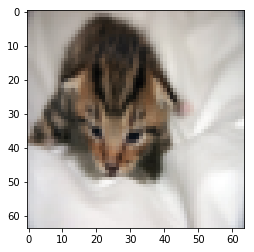

In [18]:
# 测试
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px,num_px,3)))
print("y=" + str(test_set_y[:,index]) + ",it's a " + classes[np.squeeze(test_set_y[:,index])].decode("utf-8"))


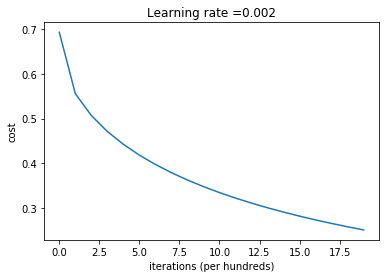

In [19]:
# 画图
costs = np.squeeze(res['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(res["learning_rate"]))
plt.show()

学习率：0.02
train accuracy: 100.0 %
test accuracy: 68.0 %

学习率：0.002
train accuracy: 95.69377990430623 %
test accuracy: 74.0 %

学习率：0.0002
train accuracy: 74.16267942583733 %
test accuracy: 56.0 %



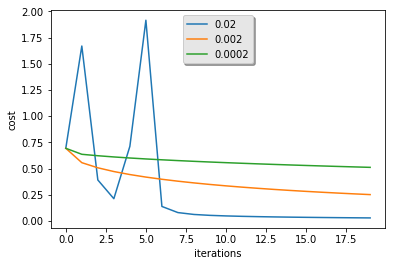

In [20]:
# 调整学习率
learning_rates = [0.02, 0.002, 0.0002]
models = {}
for i in learning_rates:
    print("学习率：" + str(i))
    models[str(i)] = logistic_regression_model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = i, print_cost = False)
    print()

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))


plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
                                                                

y=1.0  It's a cat


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


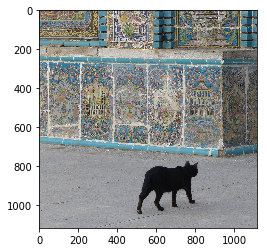

In [26]:
#测试自己的图片
my_image = "cat_in_iran.jpg"
fname = "images/" + my_image
image = np.array(ndimage.imread(fname,flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(res["w"], res["b"], my_image)

plt.imshow(image)
print("y=" + str(np.squeeze(my_predicted_image)) + "  It's a " + classes[int(np.squeeze(my_predicted_image))].decode("utf-8"))